## 1.引言
前文从零认识自注意力我们一步一步实现了标准自注意力，本文将结合因果关系对自注意力机制进行增强。

因果关系改进主要是防止模型访问序列中的未来信息，这对于语言模型的训练任务至关重要，在这些任务中，每个词的预测只能依赖于之前的词。

# 2. 因果自注意力
与标准自注意力一次允许访问访问整个输入序列不同的是，因果自注意力会遮蔽序列中当前位置之后的输入，限制模型在计算注意力得分时，只能访问当前位置及之前的token，因此也被称为遮蔽注意力(masked_attention)。

为了实现这一点，我们需要对每个查询token遮蔽掉当前位置之后的后续token，如下所示
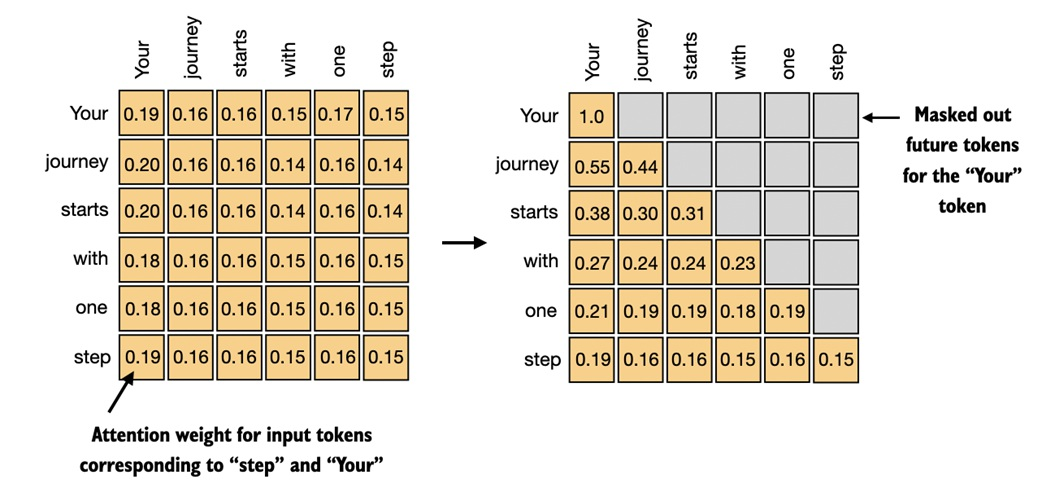

> 在上面的图中，我们遮蔽了对角线以上的注意力权重，对于token journey，只保留your(之前的token）和journey(当前位置）的注意力权重。

下面，我们将通过一步一步的运算来实现这个遮蔽效果。

## 2.1 注意力遮蔽
首先，我们引进上一节编写的SelfAttentionV1代码及inputs数据，如同上一节所做的那样，使用softmax函数计算注意力权重。

In [2]:
%run attention_v1.py

In [7]:
torch.manual_seed(123)
atten = SelfAttentionV1(inputs.shape[-1], inputs.shape[-1])
atten.forward(inputs)

tensor([[0.6692, 1.0276, 1.1106],
        [0.6864, 1.0577, 1.1389],
        [0.6860, 1.0570, 1.1383],
        [0.6738, 1.0361, 1.1180],
        [0.6711, 1.0307, 1.1139],
        [0.6783, 1.0441, 1.1252]], grad_fn=<MmBackward0>)

In [8]:
q = inputs @ atten.Wq
k = inputs @ atten.Wk
atten_scores = q @ k.T
old_atten_weights = torch.softmax(atten_scores/atten.dim_out ** 0.5, dim=-1)
old_atten_weights

tensor([[0.1747, 0.1866, 0.1864, 0.1446, 0.1586, 0.1491],
        [0.1862, 0.2123, 0.2117, 0.1179, 0.1450, 0.1269],
        [0.1859, 0.2118, 0.2112, 0.1184, 0.1454, 0.1273],
        [0.1798, 0.1936, 0.1932, 0.1365, 0.1542, 0.1427],
        [0.1751, 0.1895, 0.1893, 0.1418, 0.1579, 0.1465],
        [0.1837, 0.2003, 0.1998, 0.1293, 0.1501, 0.1369]],
       grad_fn=<SoftmaxBackward0>)

> 可以看到每个token的注意力权重是依赖所有的token，而不只是前面或自己

我们可以使用pytorch中的tril函数创建一个遮蔽，使得对角线以上的元素值为0。

In [10]:
context_length = atten_scores.shape[0]
mask = torch.tril(torch.ones(context_length, context_length))
atten_scores.shape, mask

(torch.Size([6, 6]),
 tensor([[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]]))

将这个遮蔽与注意力权重相乘，使得对角线以上的元素为零。
注意这里是元素级相乘

In [11]:
masked_atten_weights = old_atten_weights * mask
masked_atten_weights

tensor([[0.1747, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1862, 0.2123, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1859, 0.2118, 0.2112, 0.0000, 0.0000, 0.0000],
        [0.1798, 0.1936, 0.1932, 0.1365, 0.0000, 0.0000],
        [0.1751, 0.1895, 0.1893, 0.1418, 0.1579, 0.0000],
        [0.1837, 0.2003, 0.1998, 0.1293, 0.1501, 0.1369]],
       grad_fn=<MulBackward0>)

> 注：在矩阵操作中，* 和 @ 是不同的，*操作符是按位置进行元素相乘，只适用于形状相同的矩阵，运算后的形状不变。@操作符是矩阵乘法，是将第1个矩阵的行乘以第2个矩阵的列，要求第1个矩阵的列数必须等于第2个矩阵的行数。

除了遮蔽之外，我们还需要对未遮蔽的注意力权重进行标准化操作，使得剩下的注意力权重之和重新为1。

## 2.2 重新标准化
我们对遮蔽后的注意力重新进行标准化，使每一行的和再次为1，具体操作：可以将每一行的元素除以该行的总和来实现。

In [12]:
weight_sum = masked_atten_weights.sum(dim=1, keepdim=True)
print("weight_sum:", weight_sum)
renormalized_atten_weights = masked_atten_weights/weight_sum
renormalized_atten_weights, renormalized_atten_weights.sum(dim=-1)

weight_sum: tensor([[0.1747],
        [0.3985],
        [0.6089],
        [0.7031],
        [0.8535],
        [1.0000]], grad_fn=<SumBackward1>)


(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4673, 0.5327, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3054, 0.3478, 0.3468, 0.0000, 0.0000, 0.0000],
         [0.2557, 0.2753, 0.2748, 0.1942, 0.0000, 0.0000],
         [0.2051, 0.2220, 0.2217, 0.1661, 0.1851, 0.0000],
         [0.1837, 0.2003, 0.1998, 0.1293, 0.1501, 0.1369]],
        grad_fn=<DivBackward0>),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        grad_fn=<SumBackward1>))

## 2.3 高效遮蔽
但是，仔细观察上面的计算过程，会发现前后进行了两次标准化操作，计算有些冗余。实际上，在进行softmax函数计算时支持一个数学特性，可以用负无穷大值-inf来遮蔽注意力得分。

> 注：上一节简单自注意力中有提到，softmax在进行归一化之前会先对所有元素进行指数运算，指数运算时 e^-∞ 趋近于 0，所以当一行中存在负无穷大（-∞）值时，softmax 函数将其概率视为零，从而使得-inf起到遮蔽注意力得分的效果。

先创建一个上三角为1的遮蔽，并指定参数diagonal=1将主对角线向上偏移一行，表示生成的上三角矩阵中不包含主对角线。

In [13]:
mask_triu = torch.triu(torch.ones(context_length, context_length), diagonal=1)
mask_triu

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

> 注：torch.tril和torch.triu的区别在于：
torch.tril函数用于生成一个下三角矩阵，下三角（包括对角线）保留，上三角归0。
torch.triu用于生成一个上三角矩阵，矩阵的上三角（包含对角线）保留，下三角部分归0。

In [14]:
masked_scores = atten_scores.masked_fill(mask_triu.bool(), -torch.inf)
masked_scores

tensor([[0.7616,   -inf,   -inf,   -inf,   -inf,   -inf],
        [1.7872, 2.0141,   -inf,   -inf,   -inf,   -inf],
        [1.7646, 1.9901, 1.9852,   -inf,   -inf,   -inf],
        [1.0664, 1.1947, 1.1916, 0.5897,   -inf,   -inf],
        [0.8601, 0.9968, 0.9950, 0.4947, 0.6817,   -inf],
        [1.3458, 1.4957, 1.4915, 0.7374, 0.9968, 0.8366]],
       grad_fn=<MaskedFillBackward0>)

> 注：masked_fill函数的作用是用指定的值（这里为-torch.inf）对mask_triu矩阵中为True的位置做填充，mask_triu.bool()则是将非零元素都转换为True，零元素转换为False。

接下来，用softmax函数对上面的遮蔽结果进行归一化。

In [15]:
atten_weights = torch.softmax(masked_scores/atten.dim_out ** 0.5, dim=-1)
atten_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4673, 0.5327, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3054, 0.3478, 0.3468, 0.0000, 0.0000, 0.0000],
        [0.2557, 0.2753, 0.2748, 0.1942, 0.0000, 0.0000],
        [0.2051, 0.2220, 0.2217, 0.1661, 0.1851, 0.0000],
        [0.1837, 0.2003, 0.1998, 0.1293, 0.1501, 0.1369]],
       grad_fn=<SoftmaxBackward0>)

可以看到，这里的计算结果与前面两次标准化操作计算的renormalized_atten_weights结果完全相同。

最后，通过修改后的注意力权重来计算上下文向量。

In [16]:
values = inputs @ atten.Wv
context_vecs = atten_weights @ values
context_vecs

tensor([[0.4976, 0.9655, 0.7614],
        [0.7159, 1.1712, 1.1589],
        [0.7789, 1.2294, 1.2769],
        [0.7244, 1.1291, 1.1867],
        [0.6756, 1.0523, 1.1366],
        [0.6783, 1.0441, 1.1252]], grad_fn=<MmBackward0>)

# 3. Dropout
在深度学习中，Dropout是在训练过程中对隐藏状态中的数值进行随机丢弃的一种技术，丢弃的目的是为了防止过拟合，确保模型不会过度依赖特定的隐藏层单元。

这里需要强调的是：Dropout只可以在训练阶段使用，推理阶段不能使用。

下面以一个简单例子来演示dropout效果，将dropout应用于一个6x6的全为1的张量。

In [18]:
torch.manual_seed(123)
example = torch.ones(6, 6)
dropout = torch.nn.Dropout(0.5)
dropout(example)

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])

在这个示例中， 我们应用了50%的dropout率，遮蔽掉了一半的注意力权重，对应矩阵中一半的元素被置为0。

> 为了补偿元素的减少，矩阵中剩余元素的值被放在了1/0.5=2倍。这种放大对于保持注意力权重的平衡至关重要，它有助于保持注意力机制在训练阶段和推理阶段的平均影响一致。

现在我们将Dropout应用于上面计算好的注意力权重。

In [19]:
dropout(atten_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6937, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5507, 0.0000, 0.3883, 0.0000, 0.0000],
        [0.0000, 0.4439, 0.4435, 0.3322, 0.3701, 0.0000],
        [0.3673, 0.4005, 0.0000, 0.0000, 0.3003, 0.2738]],
       grad_fn=<MulBackward0>)

> 可以看到，应用dropout后，更多的注意力权重被置为0，剩余的元素则被重新缩放。

# 4. 实现CausalAttention类
在这一部分，我们将因果注意力和Dropout集成到前文实现的SelfAttention中。在此之前，还需要确保一件事：让代码支持处理多个输入序列组成的批次。

为了模拟，我们简单的复制之前的输入。

In [20]:
batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 6, 3])

> torch.stack函数的作用是将多个张量沿指定的新维度进行堆叠，dim=0表示第0维为新维度，生成的形状[2,6,3]，如果dim=1则表示第1维为新维度，生成的形状[6,2,3]，如果dim=2则表示第2维为新维度，生成的形状为[6,3,2]。

原来的二维张量（形状为[6,3]）经过堆叠后变成三维张量，包含2个文本序列，每个文本6个token，而每个token是一个三维嵌入张量。

下面实现因果注意力类，实现过程中对张量的运算需要考虑批次输入。

In [24]:
import torch
import torch.nn as nn

class CausalAttention(nn.Module):
    def __init__(self, dim_in, dim_out, context_length, dropout_rate, qkv_bias=False):
        super().__init__()
        self.dim_out = dim_out
        self.Wq = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.Wk = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.Wv = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout_rate)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, seq_len, dim = x.shape
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        atten_scores = q @ k.transpose(1, 2)  # 将第1维和第2维转置，从第0维开始
        atten_scores = atten_scores.masked_fill_(self.mask.bool()[:seq_len, :seq_len], -torch.inf)
        atten_weights = torch.softmax(atten_scores/self.dim_out ** 0.5, dim=-1)
        context_vecs = self.dropout(atten_weights) @ v
        return context_vecs

在构造方法中，我们作了两点改变，第一点是用nn.Linear代替了nn.Parameter，原因在于以下几点：

1. 内置初始化：与nn.Parameter需要我们手动用torch.rand函数来初始化有所不同，nn.Linear提供了默认的权重初始化方式；
2. 自动处理偏置：nn.Linear可以自动管理偏置，只需要指定bias参数即可，而nn.Parameter则需要额外手动创建偏置。
3. 前向传播便捷：使用nn.Linear在前向传播时只需要调用对象本身的函数Wq(x)，不需要关心矩阵乘法规则。

> 注：所有由nn.Linear创建的权重，默认情况下都会自动设置requires_grad=True，在反向传播时会自动计算梯度，不需要显式设置。

第二点是使用register_buffer注册了mask矩阵，作用在于：支持在models.to(device)时自动将mask矩阵迁移到指定设备。

> 注：默认情况下自动迁移只支持三类数据：
> 1. nn.Parameter创建的张量；
> 2. register_buffer创建的张量；
> 3. 内置模块（如nn.Linear、nn.Conv2d等）创建的参数。 而通过torch.ones、torch.rand直接创建的属于普通张量，需要手动迁移，例如：self.mask.to(device)。

在forward方法中，有两个细节作下说明：

1. 计算atten_scores时用k.transpose(1, 2)代替了k.T，用于指定在多维矩阵场景中只对第1维和第2维转置，目的是让转置操作适用于多维矩阵。
2. self.mask.bool()[:seq_len, :seq_len]的目的是对掩码矩阵进行裁剪，以确保与输入的序列长度一致。

使用上面刚封装的因果自注意力来计算上下文向量。

In [25]:
torch.manual_seed(123)
atten = CausalAttention(batch.shape[-1], batch.shape[-1], batch.shape[1], 0.2)
atten.forward(batch)

tensor([[[ 0.4158,  0.7074, -0.3914],
         [ 0.4320,  0.7063, -0.2796],
         [ 0.3128,  0.5010, -0.1396],
         [ 0.3878,  0.6176, -0.2008],
         [ 0.3038,  0.5358, -0.2053],
         [ 0.2534,  0.4165, -0.1384]],

        [[ 0.4158,  0.7074, -0.3914],
         [ 0.4320,  0.7063, -0.2796],
         [ 0.4300,  0.7005, -0.2500],
         [ 0.3878,  0.6176, -0.2008],
         [ 0.1578,  0.3140, -0.1567],
         [ 0.3309,  0.5395, -0.1719]]], grad_fn=<UnsafeViewBackward0>)

得到的上下文向量是一个三维张量，形状为 torch.Size([2, 6, 3])。

小结：本节我们从因果注意力的概念开始，详细解读了注意力遮蔽的实现过程，随后对dropout以及dropout后的数据缩放进行了演示，最后在前一节的基础上实现了一个因果注意力类。下一节，我们将讨论多头注意力机制